## TXS 0506+056

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import astropy.units as u
from astropy.coordinates import SkyCoord

# Source info

In [2]:
# A TXS-like source (see IceCube et al. 2018)
txs_coords = SkyCoord(ra=77.36 * u.deg, dec=5.69 * u.deg, frame="icrs")
txs_z = 0.3365
#txs_Emin = (200 * u.TeV).to(u.GeV)
#txs_Emax = (7.5 * u.PeV).to(u.GeV) 
txs_Emin = (10 * u.TeV).to(u.GeV)
txs_Emax = (100 * u.PeV).to(u.GeV) 

# An IC170922-like event + nu observations
ic_Edet = (23.7 * u.TeV).to(u.GeV) # IceCube et al. 2018

ic_Emin_det = (20 * u.TeV).to(u.GeV)

#ic_src_index = 2.13 # IceCube et al. 2018 
#ic_L = 2.1e46 
#ic_L = 3e45 * (u.erg/u.s) # Value from ps constraints (flux_norm @ 100 TeV ~ 5e-16 1/(GeVms))
ic_L = 5e46 * (u.erg / u.s) # Nex_src ~ 1
ic_src_index = 2.0

ic_diff_norm = (2e-18 * 4 * np.pi * (1 / (u.GeV * u.cm**2 * u.s))).to(1/(u.GeV * u.m**2 * u.s))
ic_diff_index = 2.6
ic_T = 0.5 * u.year
ic_ang_res = 0.7 * u.deg
ic_ra = 77.43 * u.deg 
ic_dec = 5.79 * u.deg 

In [3]:
from hierarchical_nu.source.parameter import Parameter
from hierarchical_nu.source.source import Sources, PointSource

In [4]:
# Define parameters
Parameter.clear_registry()

src_index = Parameter(ic_src_index, "src_index", fixed=False, par_range=(1, 4))
diff_index = Parameter(ic_diff_index, "diff_index", fixed=False, par_range=(1, 4))
L = Parameter(ic_L, "luminosity", fixed=True, 
              par_range=(0, 1e60)*(u.erg/u.s))
diffuse_norm = Parameter(ic_diff_norm, "diffuse_norm", fixed=True, 
                         par_range=(0, np.inf))
Enorm = Parameter(1e5 * u.GeV, "Enorm", fixed=True)
Emin = Parameter(txs_Emin, "Emin", fixed=True)
Emax = Parameter(txs_Emax, "Emax", fixed=True)
Emin_src = Parameter(Emin.value * (1 + txs_z), "Emin_src", fixed=True)
Emax_src = Parameter(Emax.value * (1 + txs_z), "Emax_src", fixed=True)
Emin_diff = Parameter(Emin.value, "Emin_diff", fixed=True)
Emax_diff = Parameter(Emax.value, "Emax_diff", fixed=True)

Emin_det = Parameter(ic_Emin_det, "Emin_det", fixed=True)

In [5]:
from hierarchical_nu.detector.input import mceq

In [6]:
# Define sources
point_source = PointSource.make_powerlaw_source("TXS", txs_coords.dec.to(u.rad),
                                                txs_coords.ra.to(u.rad), 
                                                L, src_index, txs_z, Emin, Emax)

my_sources = Sources()
my_sources.add(point_source)

# auto diffuse component 
my_sources.add_diffuse_component(diffuse_norm, Enorm.value, diff_index, Emin_diff, Emax_diff) 
my_sources.add_atmospheric_component(cache_dir=mceq) # auto atmo component

In [7]:
point_source.flux_model._spectral_shape._parameters["norm"]

Parameter TXS_norm = 8.989070137436106e-15 1 / (GeV s m2), fixed = True

In [8]:
my_sources.f_arr() # Associated fraction of arrival flux

<Quantity 0.00116244>

In [9]:
my_sources.f_arr_astro() # As above, excluding atmo

<Quantity 0.01884764>

## ROI

In [10]:
from hierarchical_nu.utils.roi import CircularROI

In [11]:
roi = CircularROI(txs_coords, 5 * u.deg, apply_roi=True)

## Simulation

In [12]:
from hierarchical_nu.simulation import Simulation
from hierarchical_nu.detector.icecube import IC86_II

In [13]:
obs_time = ic_T

sim = Simulation(my_sources, IC86_II, obs_time)
#sim = Simulation(my_sources, IceCubeDetectorModel, obs_time)

In [14]:
sim.precomputation()
sim.generate_stan_code()
#sim.set_stan_filename(".stan_files/sim_code_asimov.stan")
sim.compile_stan_code()

17:43:13 - cmdstanpy - INFO - compiling stan file /Users/tharacaba/Desktop/MPP/.stan_files/sim_code.stan to exe file /Users/tharacaba/Desktop/MPP/.stan_files/sim_code
17:43:43 - cmdstanpy - INFO - compiled model executable: /Users/tharacaba/Desktop/MPP/.stan_files/sim_code


In [15]:
sim.run(verbose=True, seed=173) 
sim.save("txs_sim.h5", overwrite=True)
#sim.save("output/test_sim.h5")

Running a simulation with expected Nnu = 1.74 events


17:43:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

17:43:45 - cmdstanpy - INFO - CmdStan done processing.


PosixPath('/Users/tharacaba/Desktop/MPP/txs_sim.h5')

In [16]:
sim._expected_Nnu_per_comp

array([1.50052799, 0.04449036, 0.19806281])

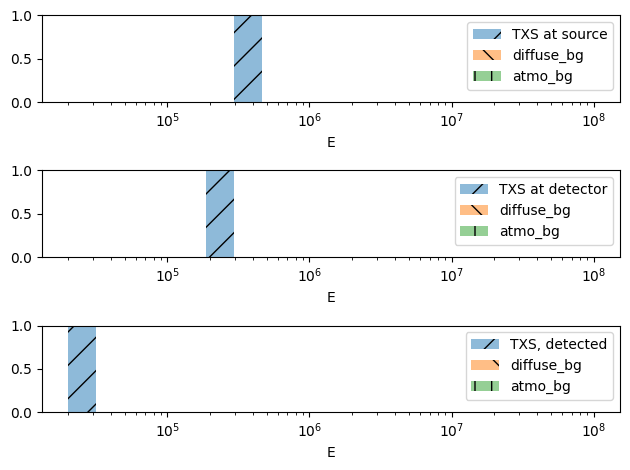

In [17]:
fig, ax = sim.show_spectrum()
fig.tight_layout()

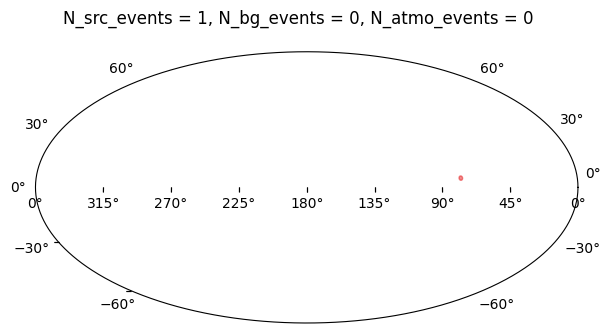

In [18]:
fig, ax = sim.show_skymap()

In [19]:
sim.events.energies

<Quantity [21037.3] GeV>

## Fit

In [20]:
from hierarchical_nu.events import Events
from hierarchical_nu.fit import StanFit
from hierarchical_nu.priors import Priors, LogNormalPrior, NormalPrior, FluxPrior, LuminosityPrior, IndexPrior

In [21]:
events = Events.from_file("txs_sim.h5")
#events = sim.events
obs_time = ic_T

In [22]:
# Different prior means to try
L_prior_mean = 1e46 * (u.GeV / u.s)
L_prior_width = 8
src_index_prior_mean = 2.0
src_index_prior_width = 0.1

priors = Priors()

flux_units = 1 / (u.m**2 * u.s)

atmo_flux = my_sources.atmospheric.flux_model.total_flux_int.to(flux_units)
diff_flux = my_sources.diffuse.flux_model.total_flux_int.to(flux_units)

priors.atmospheric_flux = FluxPrior(LogNormalPrior, mu=atmo_flux, sigma=0.1)
priors.diffuse_flux = FluxPrior(LogNormalPrior, mu=diff_flux, sigma=0.1)
priors.diff_index = IndexPrior(mu=diff_index.value, sigma=0.1)
priors.src_index = IndexPrior(mu=src_index_prior_mean, sigma=src_index_prior_width)
priors.luminosity = LuminosityPrior(mu=L_prior_mean, sigma=L_prior_width)

In [23]:
fit = StanFit(my_sources, IC86_II, events, obs_time, nshards=10, priors=priors)
#fit = StanFit(my_sources, IceCubeDetectorModel, events, obs_time, priors=priors, nshards=0)

In [24]:
import time

In [25]:
fit.precomputation()
fit.generate_stan_code()
fit.compile_stan_code()
start_time = time.time()
fit.run(show_progress=True, show_console=True, seed=9856845, iterations=1000, iter_warmup=1000, chains=4)
time_taken = time.time() - start_time

17:44:05 - cmdstanpy - INFO - compiling stan file /Users/tharacaba/Desktop/MPP/.stan_files/model_code.stan to exe file /Users/tharacaba/Desktop/MPP/.stan_files/model_code
17:44:27 - cmdstanpy - INFO - compiled model executable: /Users/tharacaba/Desktop/MPP/.stan_files/model_code
17:44:27 - cmdstanpy - INFO - CmdStan start processing


method = sample (Default)
sample
num_samples = 1000 (Default)
num_warmup = 1000 (Default)
save_warmup = false (Default)
thin = 1 (Default)
adapt
engaged = true (Default)
gamma = 0.05 (Default)
delta = 0.8 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = false (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 4
id = 1 (Default)
data
file = /var/folders/x8/tt4g51ms52n_rxzkb66gyznh0000gn/T/tmpufxnarp1/xgbvx7so.json
init = 2 (Default)
random
seed = 9856845
output
file = /var/folders/x8/tt4g51ms52n_rxzkb66gyznh0000gn/T/tmpufxnarp1/model_code1ih_5370/model_code-20240918174427.csv
diagnostic_file =  (Default)
refresh = 100 (Default)
sig_figs = -1 (Default)
profile_file = profile.csv (Default)
save_cmdstan_config = false (Default)
num_threads = 

17:44:30 - cmdstanpy - INFO - CmdStan done processing
17:44:30 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 205 divergent transitions (20.5%)
	Chain 2 had 2 divergent transitions (0.2%)
	Chain 3 had 37 divergent transitions (3.7%)
	Chain 4 had 3 divergent transitions (0.3%)
	Use function "diagnose()" to see further information.



Elapsed Time: 1.342 seconds (Warm-up)
1.376 seconds (Sampling)
2.718 seconds (Total)




In [26]:
time_taken

3.447059154510498

In [27]:
fit._fit_output.diagnose()

"Processing csv files: /var/folders/x8/tt4g51ms52n_rxzkb66gyznh0000gn/T/tmpufxnarp1/model_code1ih_5370/model_code-20240918174427_1.csv, /var/folders/x8/tt4g51ms52n_rxzkb66gyznh0000gn/T/tmpufxnarp1/model_code1ih_5370/model_code-20240918174427_2.csv, /var/folders/x8/tt4g51ms52n_rxzkb66gyznh0000gn/T/tmpufxnarp1/model_code1ih_5370/model_code-20240918174427_3.csv, /var/folders/x8/tt4g51ms52n_rxzkb66gyznh0000gn/T/tmpufxnarp1/model_code1ih_5370/model_code-20240918174427_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\n247 of 4000 (6.17%) transitions ended with a divergence.\nThese divergent transitions indicate that HMC is not fully able to explore the posterior distribution.\nTry increasing adapt delta closer to 1.\nIf this doesn't remove all divergences, try to reparameterize the model.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size sa

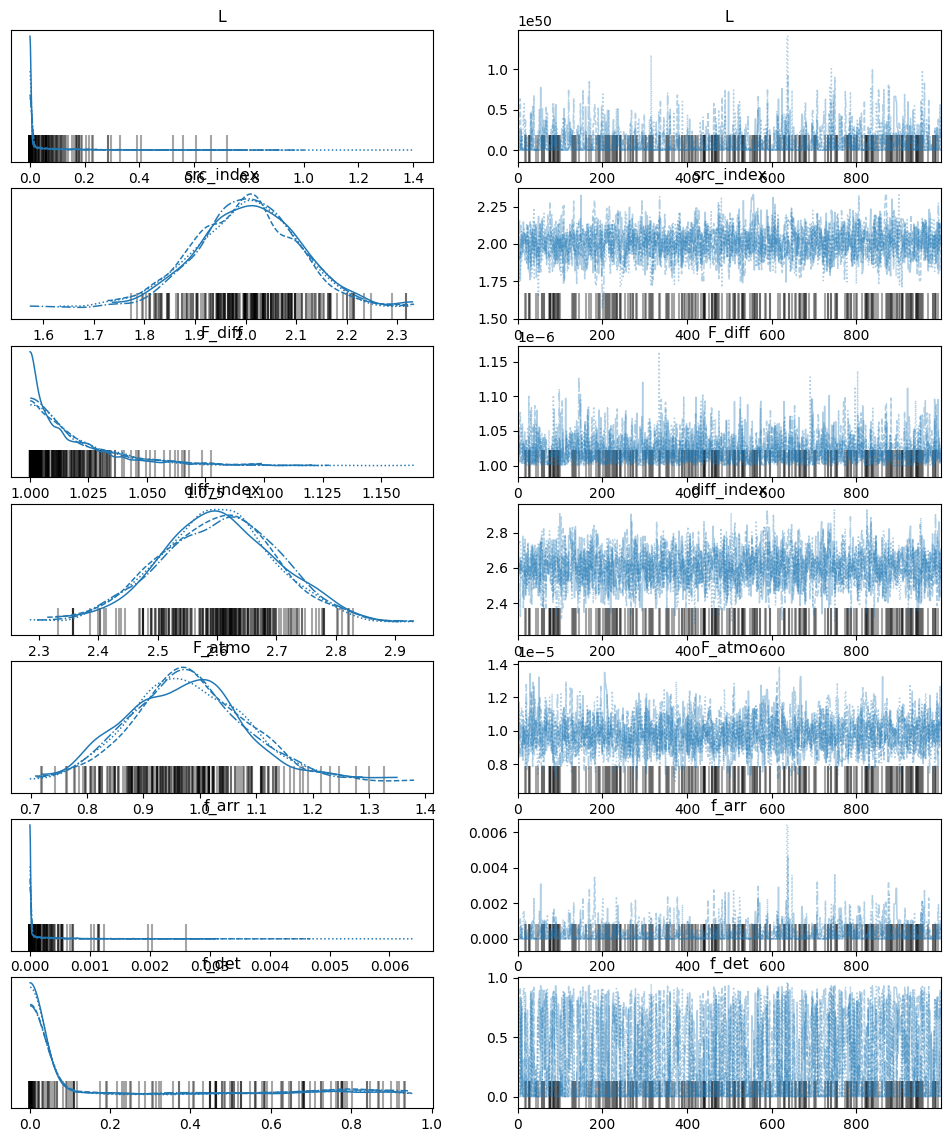

In [28]:
fit.plot_trace()
fig.tight_layout()

In [29]:
from hierarchical_nu.simulation import SimInfo

If you are in a reloaded state with multiple point sources, add the used source list through <StanFit._sources = sources>


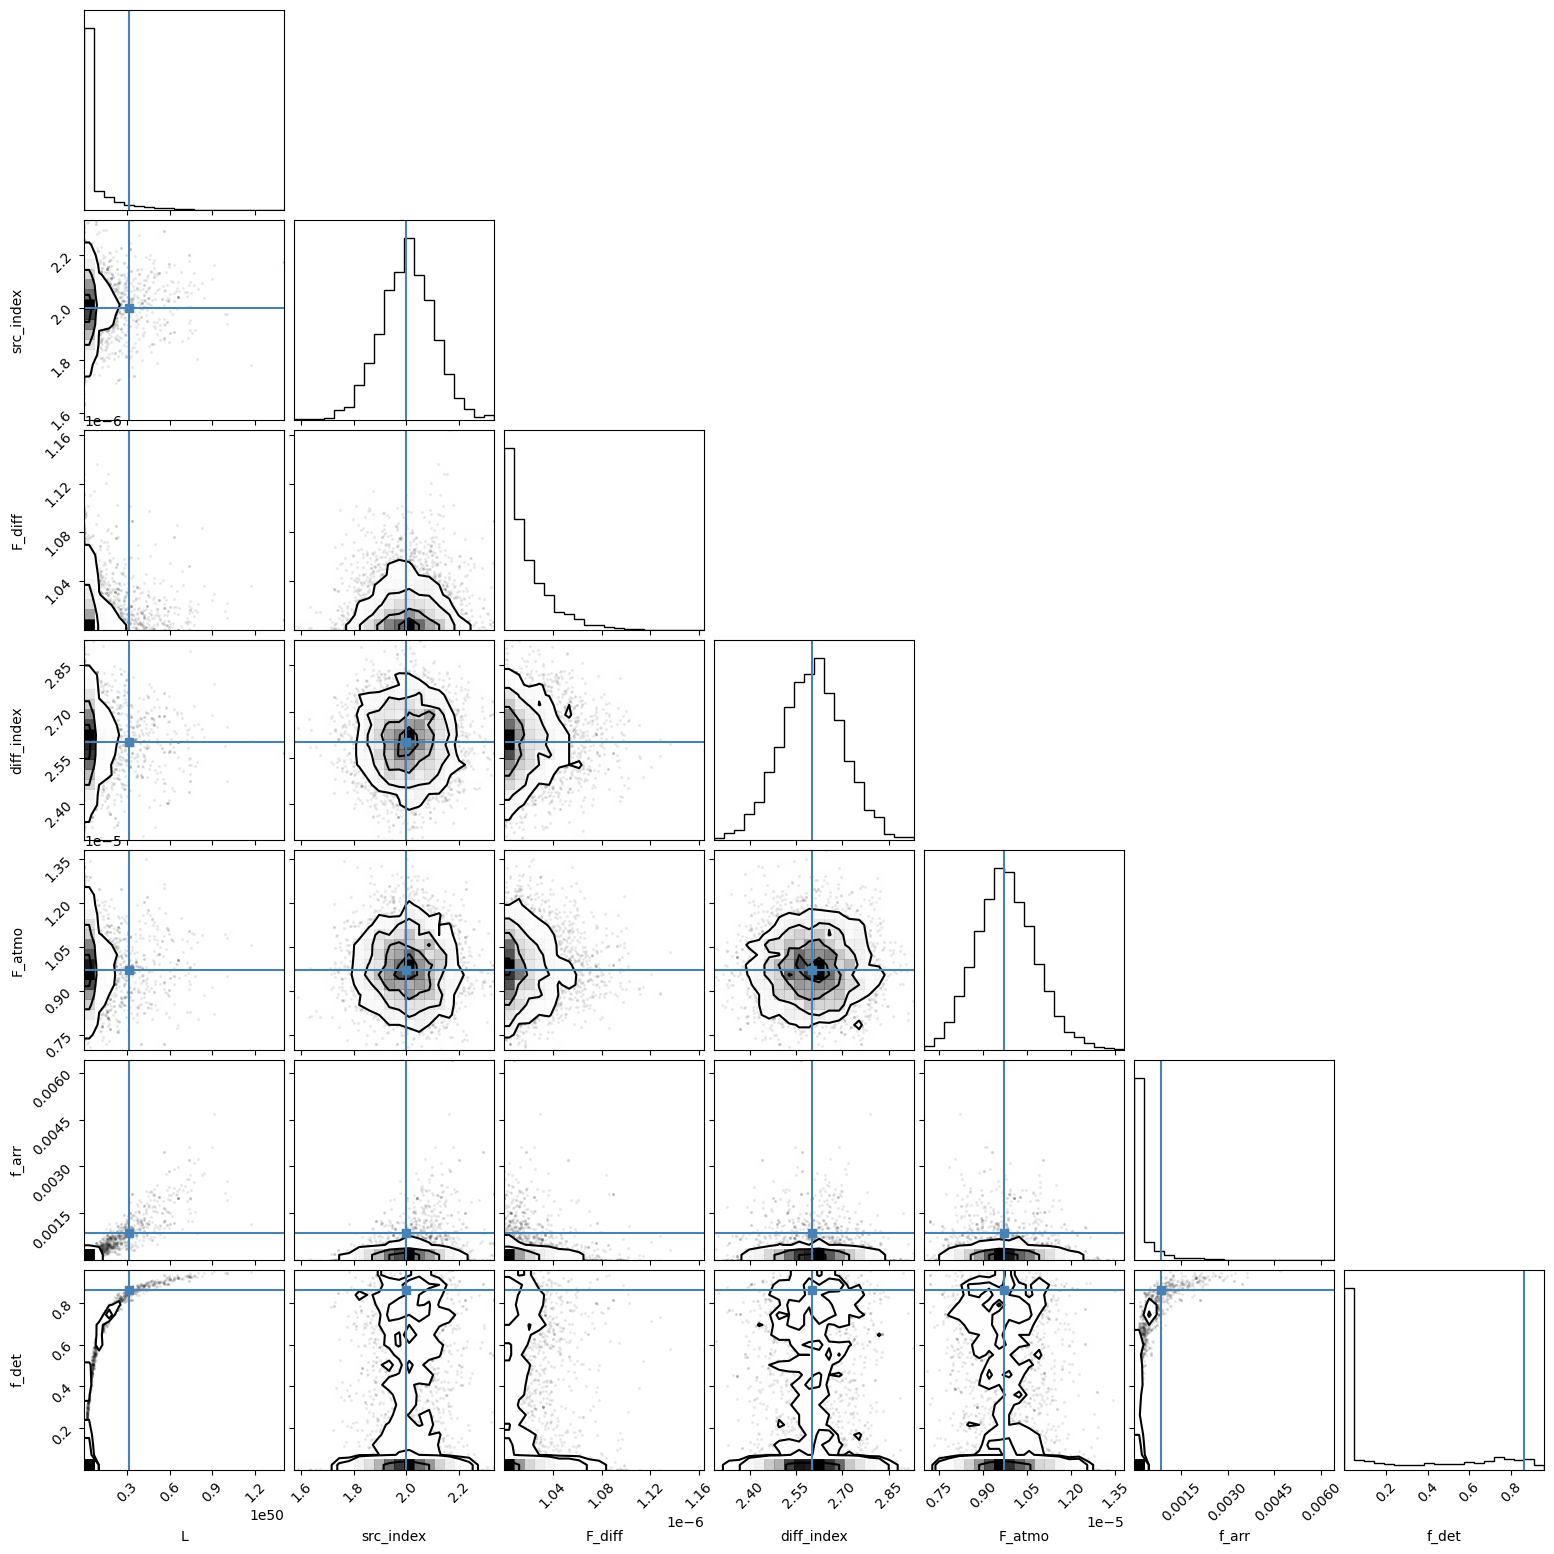

In [30]:
sim_info = SimInfo.from_file("txs_sim.h5")
fig = fit.corner_plot(truths=sim_info.truths)

In [31]:
_ = fit.check_classification(sim_info.outputs)

Event 0 is misclassified
P(src0) = 0.325000
P(diff) = 0.113018
P(atmo) = 0.561982
The correct component is src0
A total of 1 events out of 1 are misclassified


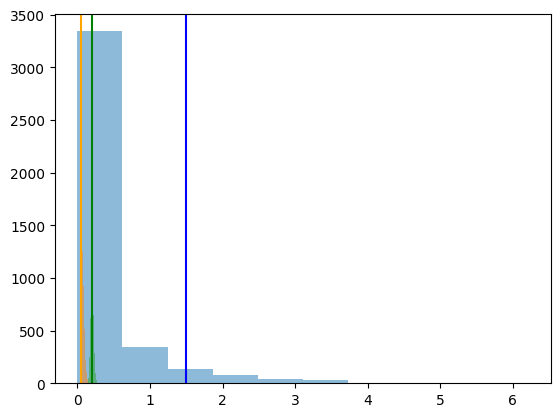

In [32]:
fig, ax = plt.subplots()
ax.hist(fit._fit_output.stan_variable("Nex_src"), alpha=0.5);
ax.hist(fit._fit_output.stan_variable("Nex_diff"), alpha=0.5);
ax.hist(fit._fit_output.stan_variable("Nex_atmo"), alpha=0.5)
ax.axvline(sim._expected_Nnu_per_comp[0], color="blue")
ax.axvline(sim._expected_Nnu_per_comp[1], color="orange")
ax.axvline(sim._expected_Nnu_per_comp[2], color="green")

## Fit with similar reconstructed event

In [33]:
from icecube_tools.utils.vMF import get_kappa

In [34]:
sim_info = SimInfo.from_file("txs_sim.h5")
events = Events.from_file("txs_sim.h5")

obs_time = ic_T

labels = sim_info.outputs["Lambda"] - 1
source = np.where(labels==0)[0]
if len(source) != 1:
    print("There is not 1 source event in this event list!")

INFO:hierarchical_nu.events:Applying ROIs to event selection
INFO:hierarchical_nu.events:Applying Emin_det=20000.0 GeV to event selection.


In [35]:
# IC170922A-like values 
events.energies[source] = ic_Edet
events.ang_errs[source] = 0.7 * u.deg
events.kappas[source] = get_kappa(ic_ang_res.to_value(u.deg), p=0.683)

ic_coord = SkyCoord(ra=ic_ra, dec=ic_dec, distance=1, frame="icrs")
ic_coord.representation_type = "cartesian"
new_coord = SkyCoord(x=ic_coord.x, y=ic_coord.y, z=ic_coord.z, frame="icrs", representation_type="cartesian")
events.coords[source] = new_coord
events.unit_vectors[source][:] = np.array([ic_coord.x, ic_coord.y, ic_coord.z])

"""
rm_idx = np.where(events.energies==np.max(events.energies[labels==1]))[0].squeeze()
labels = np.delete(labels, rm_idx)
events.remove(rm_idx)
"""

events.to_file("txs_ev.h5")

In [36]:
events = Events.from_file("txs_ev.h5")

INFO:hierarchical_nu.events:Applying ROIs to event selection
INFO:hierarchical_nu.events:Applying Emin_det=20000.0 GeV to event selection.


In [37]:
#priors = Priors()
#priors.atmospheric_flux = LogNormalPrior(mu=np.log(atmo_flux), sigma=0.1)
#priors.diffuse_flux = LogNormalPrior(mu=np.log(diff_flux), sigma=0.1)

#priors.diff_index = NormalPrior(mu=diff_index.value, sigma=0.1)
#priors.src_index = NormalPrior(mu=2.0, sigma=0.1)

#L_mean = 1e35 * (u.erg/u.s)
#priors.luminosity = LogNormalPrior(mu=np.log(L_mean.to_value(u.GeV/u.s)), sigma=8)
#priors.luminosity = NormalPrior(mu=0.0, sigma=L_mean.to_value(u.GeV/u.s))

# Different prior means to try
L_prior_mean = 1e46 * (u.GeV / u.s)
L_prior_width = 8
src_index_prior_mean = 2.0
src_index_prior_width = 0.1

priors = Priors()

flux_units = 1 / (u.m**2 * u.s)

atmo_flux = my_sources.atmospheric.flux_model.total_flux_int.to(flux_units)
diff_flux = my_sources.diffuse.flux_model.total_flux_int.to(flux_units)

priors.atmospheric_flux = FluxPrior(LogNormalPrior, mu=atmo_flux, sigma=0.1)
priors.diffuse_flux = FluxPrior(LogNormalPrior, mu=diff_flux, sigma=0.1)
priors.diff_index = IndexPrior(mu=diff_index.value, sigma=0.1)
priors.src_index = IndexPrior(mu=src_index_prior_mean, sigma=src_index_prior_width)
priors.luminosity = LuminosityPrior(mu=L_prior_mean, sigma=L_prior_width)

In [38]:
fit = StanFit(my_sources, IC86_II, events, obs_time, nshards=10, priors=priors)

fit.precomputation()
fit.generate_stan_code()
fit.compile_stan_code()

fit.run(show_progress=True, show_console=True, seed=1, iterations=1000, iter_warmup=1000, chains=4)

INFO:hierarchical_nu.detector.r2021.R2021DetectorModel:Generating r2021 stan code.
DEBUG:cmdstanpy:Removing /Users/tharacaba/Desktop/MPP/.stan_files/model_code
17:44:53 - cmdstanpy - INFO - compiling stan file /Users/tharacaba/Desktop/MPP/.stan_files/model_code.stan to exe file /Users/tharacaba/Desktop/MPP/.stan_files/model_code
INFO:cmdstanpy:compiling stan file /Users/tharacaba/Desktop/MPP/.stan_files/model_code.stan to exe file /Users/tharacaba/Desktop/MPP/.stan_files/model_code
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--include-paths=/Users/tharacaba/opt/anaconda3/envs/MPP/lib/python3.11/site-packages/hierarchical_nu/stan,/Users/tharacaba/Desktop/MPP/.stan_files STAN_THREADS=True /Users/tharacaba/Desktop/MPP/.stan_files/model_code
cwd: /Users/tharacaba/.cmdstan/cmdstan-2.35.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --include-paths=/Users/tharacaba/opt/anaconda3/envs/MPP/lib/python3.11/site-packages/hierarchical_nu/stan,/Users/tharacaba/Des

method = sample (Default)
sample
num_samples = 1000 (Default)
num_warmup = 1000 (Default)
save_warmup = false (Default)
thin = 1 (Default)
adapt
engaged = true (Default)
gamma = 0.05 (Default)
delta = 0.8 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = false (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 4
id = 1 (Default)
data
file = /var/folders/x8/tt4g51ms52n_rxzkb66gyznh0000gn/T/tmpufxnarp1/t6iifiwt.json
init = 2 (Default)
random
seed = 1
output
file = /var/folders/x8/tt4g51ms52n_rxzkb66gyznh0000gn/T/tmpufxnarp1/model_codewt3ik_jv/model_code-20240918174517.csv
diagnostic_file =  (Default)
refresh = 100 (Default)
sig_figs = -1 (Default)
profile_file = profile.csv (Default)
save_cmdstan_config = false (Default)
num_threads = 40 (De

17:45:21 - cmdstanpy - INFO - CmdStan done processing
INFO:cmdstanpy:CmdStan done processing
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=1
 cmd (chain 1):
	['/Users/tharacaba/Desktop/MPP/.stan_files/model_code', 'id=1', 'random', 'seed=1', 'data', 'file=/var/folders/x8/tt4g51ms52n_rxzkb66gyznh0000gn/T/tmpufxnarp1/t6iifiwt.json', 'output', 'file=/var/folders/x8/tt4g51ms52n_rxzkb66gyznh0000gn/T/tmpufxnarp1/model_codewt3ik_jv/model_code-20240918174517.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1', 'num_chains=4']
 retcodes=[0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/var/folders/x8/tt4g51ms52n_rxzkb66gyznh0000gn/T/tmpufxnarp1/model_codewt3ik_jv/model_code-20240918174517_1.csv
 console_msgs (if any):
	/var/folders/x8/tt4g51ms52n_rxzkb66gyznh0000gn/T/tmpufxnarp1/model_codewt3ik_jv/model_code-20240918174517-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample


Elapsed Time: 1.969 seconds (Warm-up)
2.037 seconds (Sampling)
4.006 seconds (Total)




(<Figure size 1200x1400 with 14 Axes>,
 array([[<Axes: title={'center': 'L'}>, <Axes: title={'center': 'L'}>],
        [<Axes: title={'center': 'src_index'}>,
         <Axes: title={'center': 'src_index'}>],
        [<Axes: title={'center': 'F_diff'}>,
         <Axes: title={'center': 'F_diff'}>],
        [<Axes: title={'center': 'diff_index'}>,
         <Axes: title={'center': 'diff_index'}>],
        [<Axes: title={'center': 'F_atmo'}>,
         <Axes: title={'center': 'F_atmo'}>],
        [<Axes: title={'center': 'f_arr'}>,
         <Axes: title={'center': 'f_arr'}>],
        [<Axes: title={'center': 'f_det'}>,
         <Axes: title={'center': 'f_det'}>]], dtype=object))

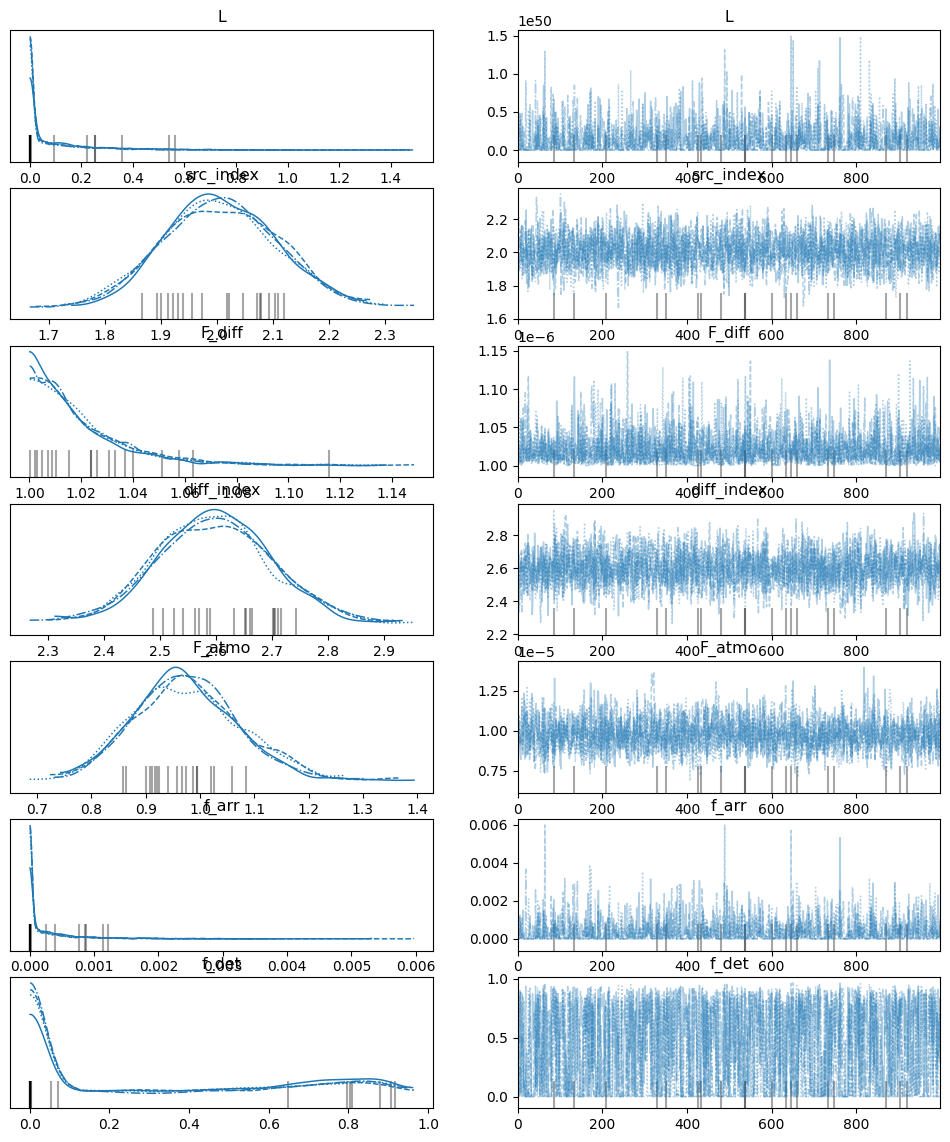

In [39]:
fit.plot_trace()

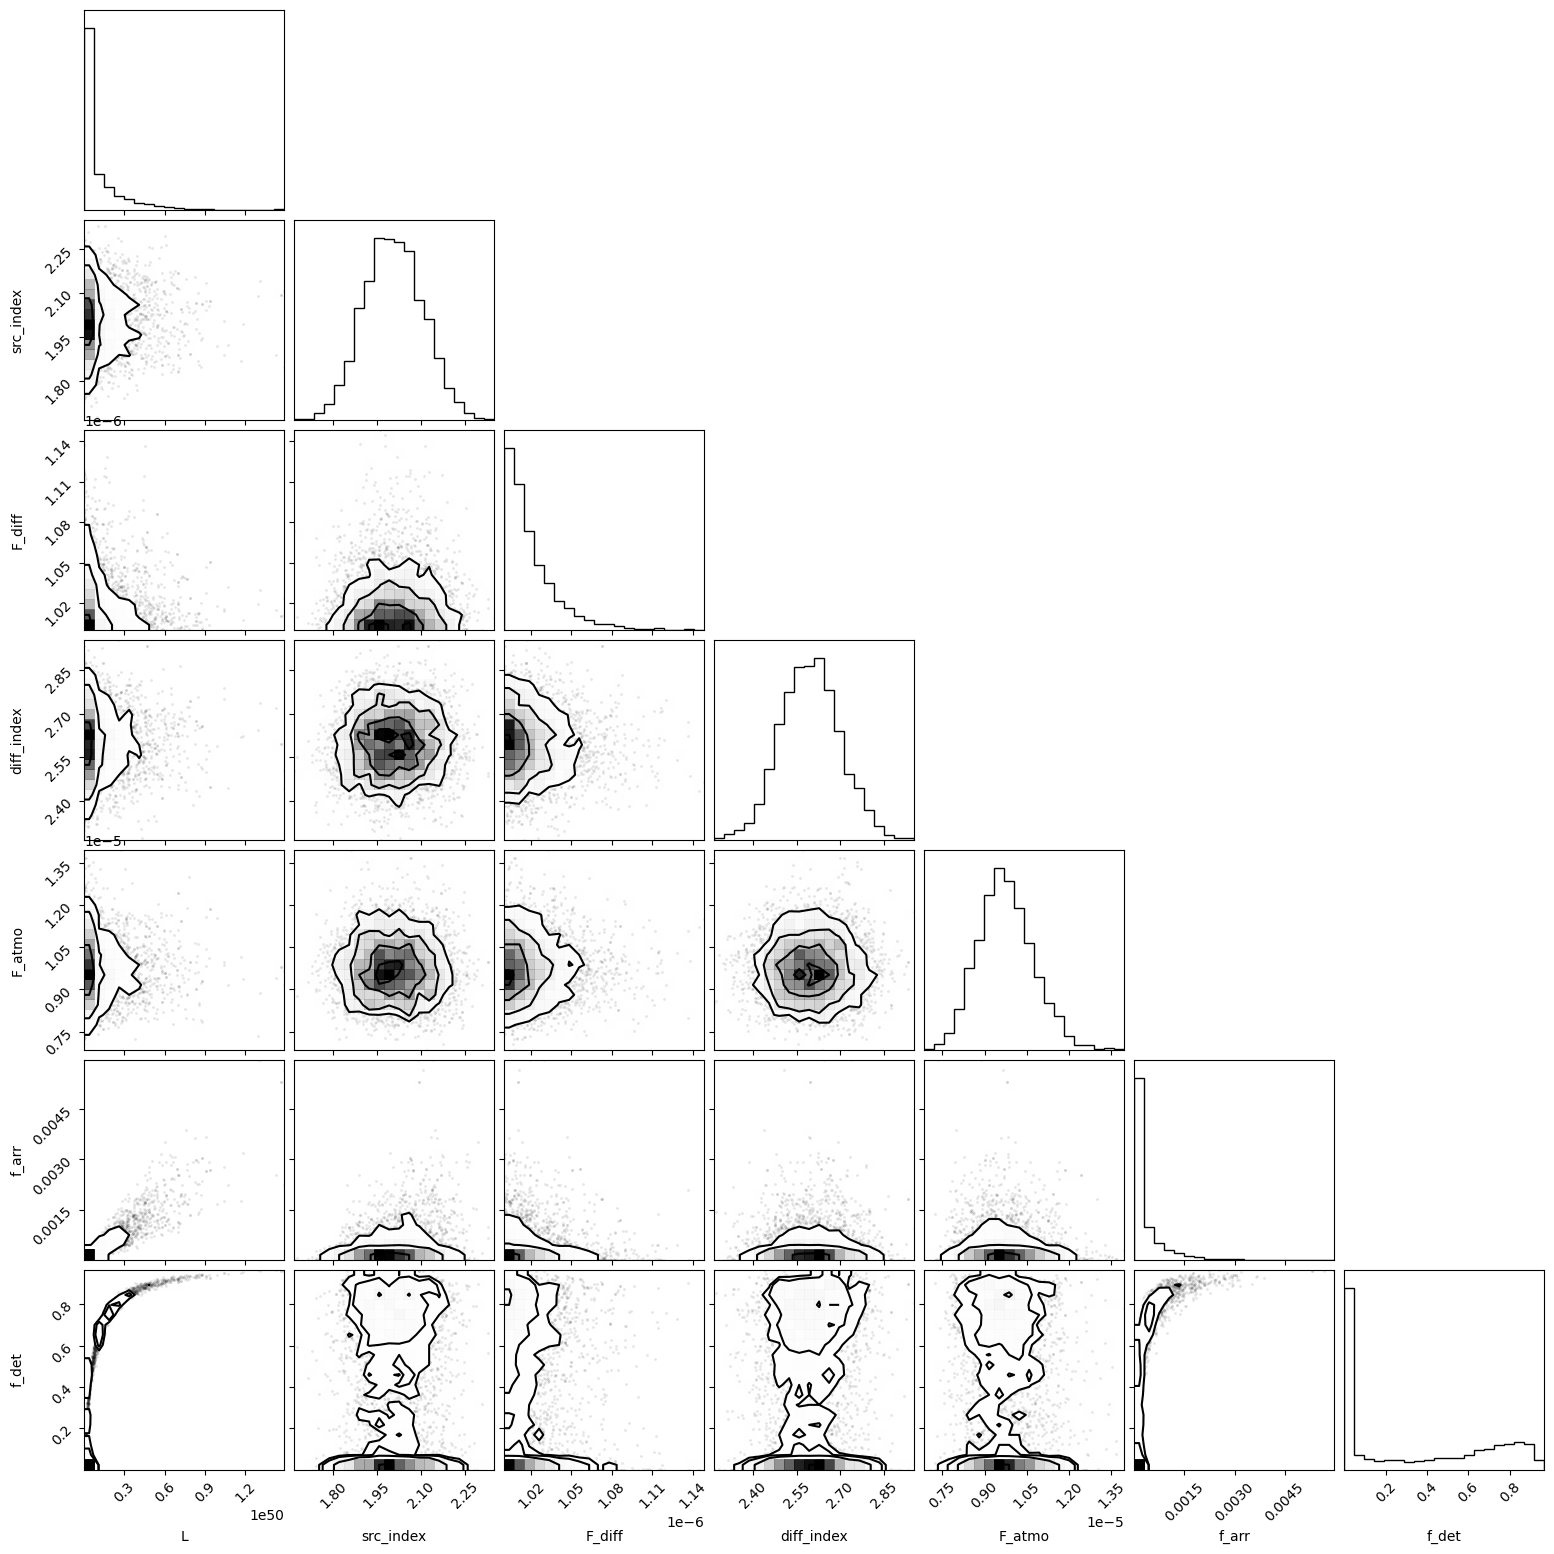

In [40]:
sim_info = SimInfo.from_file("txs_sim.h5")
fig = fit.corner_plot()

In [41]:
# Check association probability
prob_each_src = np.array(fit._get_event_classifications())
p_src = prob_each_src[source].squeeze()[0]
print("Assoc. prob = %.5f" % p_src)
#prob_each_src

Assoc. prob = 0.54220


In [42]:
prob_each_src

array([[0.54219693, 0.08264736, 0.37515571]])